In [1]:
from transformer import Transformer
import pandas as pd
import numpy as np
import tqdm
import re
import torch 

#setting up the eviorment
import torch
import gpytorch
from gpytorch.models import ExactGP
from gpytorch.means import ConstantMean
from gpytorch.kernels import RBFKernel, ScaleKernel, PeriodicKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.distributions import MultivariateNormal
import matplotlib.pyplot as plt
from gpytorch.priors import LogNormalPrior
from gpytorch.constraints import Interval

<h2>Loading Split Data</h2>

In [2]:
####Training Set 1#####
# Load the CSV file
training_set_1_df = pd.read_csv('training_set_1.csv')
test_set_1_df = pd.read_csv('test_set_1.csv')

# Access the arrays
z_training_set_1 = training_set_1_df['z_target (m)'].values
TOD_training_set_1 = training_set_1_df['TOD (s^3)'].values
n_protons_train_set_1 = training_set_1_df['n_protons (1/sr)'].values

z_test_set_1 = test_set_1_df['z_target (m)'].values
TOD_test_set_1 = test_set_1_df['TOD (s^3)'].values
n_protons_test_set_1 = test_set_1_df['n_protons (1/sr)'].values

####Training Set 2#####
# Load the CSV file
training_set_2_df = pd.read_csv('training_set_2.csv')
test_set_2_df = pd.read_csv('test_set_2.csv')

# Access the arrays
z_training_set_2 = training_set_2_df['z_target (m)'].values
TOD_training_set_2 = training_set_2_df['TOD (s^3)'].values
n_protons_training_set_2 = training_set_2_df['n_protons (1/sr)'].values

z_test_set_2 = test_set_2_df['z_target (m)'].values
TOD_test_set_2 = test_set_2_df['TOD (s^3)'].values
n_protons_test_set_2 = test_set_2_df['n_protons (1/sr)'].values

<h2>Normalizing Data</h2>

In [3]:
#Setting Bounds
z_bounds = torch.tensor([-150, 150])
TOD_bounds = torch.tensor([-80e3, 80e3])
protons_bounds = torch.tensor([min(n_protons_train_set_1), max(n_protons_train_set_1)])


#define transformers
transformer_z = Transformer(z_bounds.reshape(2,1), transform_type = 'normalize')
transformer_TOD = Transformer(TOD_bounds.reshape(2,1), transform_type = 'normalize')
transformer_n_protons = Transformer(protons_bounds.reshape(2,1), transform_type = 'normalize')


#Full normalization process
def normalization(array, transformer):
    array = np.array(array).reshape(-1,1)
    array = torch.tensor(array)
    norm = transformer.forward(array)
    return norm

In [4]:
# Normalize datasets 1
normed_z_train_set_1 = normalization(z_training_set_1, transformer_z)
normed_TOD_train_set_1 = normalization(TOD_training_set_1, transformer_TOD)
normed_n_train_set_1 = normalization(n_protons_train_set_1, transformer_n_protons)

normed_z_test_set_1 = normalization(z_test_set_1, transformer_z)
normed_TOD_test_set_1 = normalization(TOD_test_set_1, transformer_TOD)
normed_n_test_set_1 = normalization(n_protons_test_set_1, transformer_n_protons)

In [5]:
#Normalize datasets 2
normed_z_train_set_2 = normalization(z_training_set_2, transformer_z)
normed_TOD_train_set_2 = normalization(TOD_training_set_2, transformer_TOD)
normed_n_train_set_2 = normalization(n_protons_training_set_2, transformer_n_protons)

normed_z_test_set_2 = normalization(z_test_set_2, transformer_z)
normed_TOD_test_set_2 = normalization(TOD_test_set_2, transformer_TOD)
normed_n_test_set_2 = normalization(n_protons_test_set_2, transformer_n_protons)

<Figure size 640x480 with 0 Axes>

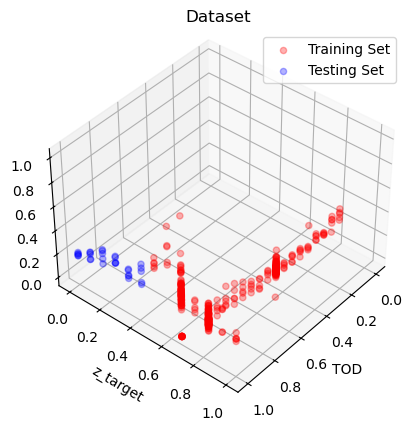

In [6]:
plt.clf()
ax = plt.figure().add_subplot(projection='3d')

ax.scatter( normed_TOD_train_set_1, normed_z_train_set_1,normed_n_train_set_1, c='r',alpha=0.3, label='Training Set')
ax.scatter( normed_TOD_test_set_1, normed_z_test_set_1,normed_n_test_set_1, c='b', alpha=0.3, label='Testing Set')
ax.view_init(elev=40., azim=40, roll=0)
plt.title('Dataset')
plt.xlabel('TOD')
plt.ylabel('z_target')
plt.legend()

<h1> Guassain Process </h1>

In [7]:
#setting up the eviorment
import numpy
from transformer import Transformer
import torch
import gpytorch
from gpytorch.models import ExactGP
from gpytorch.means import ConstantMean, Mean
from gpytorch.kernels import RBFKernel, ScaleKernel, MaternKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.distributions import MultivariateNormal

<h1> Defining the Guassain Process </h1>

In [8]:
class GPModel(ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean()
        self.covar_module = RBFKernel()

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)

# Combine the two inputs into a single tensor
train_x_1 = torch.cat([normed_z_train_set_1, normed_TOD_train_set_1], dim=1)  
train_y_1 = normed_n_train_set_1.squeeze()  # Shape should be (n_samples,)

train_x_2 = torch.cat([normed_z_train_set_2, normed_TOD_train_set_2], dim=1)  
train_y_2 = normed_n_train_set_2.squeeze()  # Shape should be (n_samples,)

# Initialize the likelihood and model
likelihood_1 = GaussianLikelihood()
model_1 = GPModel(train_x_1, train_y_1, likelihood_1)

# Initialize the likelihood and model
likelihood_2 = GaussianLikelihood()
model_2 = GPModel(train_x_2, train_y_2, likelihood_2)

<h1> Training Model </h1>

In [9]:
def train_GP(model, likelihood, train_x, train_y, train_z, training_iterations = 1500):
    inputs = torch.cat([train_x, train_y], dim=1)
    model.train()
    likelihood.train()

    # Use the Adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.009)

    # "Loss" for GPs - the marginal log likelihood
    mll = ExactMarginalLogLikelihood(likelihood, model)

    # Lists to save the values
    losses = []
    lengthscales = []
    noises = []

    for i in range(training_iterations):
        optimizer.zero_grad()
        output = model(inputs)
        loss = -mll(output, train_z)
        loss.backward()
        optimizer.step()

        # Save the loss and hyperparameters
        losses.append(loss.item())
        lengthscales.append(model.covar_module.lengthscale.item())
        noises.append(model.likelihood.noise.item())
         
        if (i + 1) % 10 == 0:
            print(f'Iter {i + 1}/{training_iterations} - Loss: {loss.item():.3f} ' +
              f'lengthscale: {model.covar_module.lengthscale.item():.3f} ' +
              f'noise: {model.likelihood.noise.item():.3f}')


    # Print the new trainable parameters for the model
    for name, param in model.named_parameters():
        print(f'model {name} : {param}')

In [10]:
train_GP(model_1, likelihood_1, normed_z_train_set_1, normed_TOD_train_set_1, normed_n_train_set_1.squeeze())

Iter 10/1500 - Loss: 0.733 lengthscale: 0.739 noise: 0.649
Iter 20/1500 - Loss: 0.700 lengthscale: 0.787 noise: 0.607
Iter 30/1500 - Loss: 0.666 lengthscale: 0.835 noise: 0.567
Iter 40/1500 - Loss: 0.631 lengthscale: 0.885 noise: 0.528
Iter 50/1500 - Loss: 0.596 lengthscale: 0.936 noise: 0.492
Iter 60/1500 - Loss: 0.560 lengthscale: 0.987 noise: 0.457
Iter 70/1500 - Loss: 0.523 lengthscale: 1.039 noise: 0.423
Iter 80/1500 - Loss: 0.486 lengthscale: 1.090 noise: 0.392
Iter 90/1500 - Loss: 0.447 lengthscale: 1.143 noise: 0.362
Iter 100/1500 - Loss: 0.409 lengthscale: 1.195 noise: 0.334
Iter 110/1500 - Loss: 0.369 lengthscale: 1.247 noise: 0.308
Iter 120/1500 - Loss: 0.330 lengthscale: 1.299 noise: 0.284
Iter 130/1500 - Loss: 0.290 lengthscale: 1.351 noise: 0.261
Iter 140/1500 - Loss: 0.249 lengthscale: 1.403 noise: 0.240
Iter 150/1500 - Loss: 0.208 lengthscale: 1.455 noise: 0.220
Iter 160/1500 - Loss: 0.167 lengthscale: 1.506 noise: 0.202
Iter 170/1500 - Loss: 0.126 lengthscale: 1.557 no

In [11]:
train_GP(model_2, likelihood_2, normed_z_train_set_2, normed_TOD_train_set_2, normed_n_train_set_2.squeeze())

Iter 10/1500 - Loss: 0.732 lengthscale: 0.739 noise: 0.649
Iter 20/1500 - Loss: 0.699 lengthscale: 0.787 noise: 0.607
Iter 30/1500 - Loss: 0.665 lengthscale: 0.836 noise: 0.567
Iter 40/1500 - Loss: 0.630 lengthscale: 0.886 noise: 0.528
Iter 50/1500 - Loss: 0.595 lengthscale: 0.937 noise: 0.492
Iter 60/1500 - Loss: 0.559 lengthscale: 0.989 noise: 0.457
Iter 70/1500 - Loss: 0.522 lengthscale: 1.041 noise: 0.423
Iter 80/1500 - Loss: 0.484 lengthscale: 1.094 noise: 0.392
Iter 90/1500 - Loss: 0.446 lengthscale: 1.147 noise: 0.362
Iter 100/1500 - Loss: 0.407 lengthscale: 1.201 noise: 0.334
Iter 110/1500 - Loss: 0.368 lengthscale: 1.255 noise: 0.308
Iter 120/1500 - Loss: 0.328 lengthscale: 1.308 noise: 0.284
Iter 130/1500 - Loss: 0.287 lengthscale: 1.362 noise: 0.261
Iter 140/1500 - Loss: 0.246 lengthscale: 1.416 noise: 0.240
Iter 150/1500 - Loss: 0.205 lengthscale: 1.470 noise: 0.220
Iter 160/1500 - Loss: 0.164 lengthscale: 1.523 noise: 0.202
Iter 170/1500 - Loss: 0.123 lengthscale: 1.577 no

<h1> Evaluating The Model </h1>

In [12]:
def eval_mode(model, likelihood, x_data, y_data):
    """
    Perform predictions using the provided model and likelihood on the given input data.

    Parameters:
    - model: The trained model.
    - likelihood: The likelihood function associated with the model.
    - x_data: The input data for which predictions are to be made.

    Returns:
    - mean_prediction: The mean predictions from the model.
    - lower_bound: The lower bound of the confidence interval.
    - upper_bound: The upper bound of the confidence interval.
    """
    inputs = torch.cat([x_data, y_data], dim=1)
    model.eval()
    likelihood.eval()

    with torch.no_grad():
        predictions = model(inputs)
        mean_prediction = predictions.mean  # Mean prediction
        lower_bound, upper_bound = predictions.confidence_region()  # Confidence interval

    return mean_prediction, lower_bound, upper_bound

In [13]:
test_mean_prediction_set_1, test_lower_set_1, test_upper_set_1 = eval_mode(model_1, likelihood_1, normed_z_test_set_1, normed_TOD_test_set_1)

In [14]:
train_mean_prediction_set_1, train_lower_set_1, train_upper_set_1 = eval_mode(model_1, likelihood_1, normed_z_train_set_1, normed_TOD_train_set_1)

/global/homes/a/adiaz/.conda/envs/andrea/lib/python3.12/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


In [15]:
test_mean_prediction_set_2, test_lower_set_2, test_upper_set_2 = eval_mode(model_2, likelihood_2, normed_z_test_set_2, normed_TOD_test_set_2)

In [16]:
train_mean_prediction_set_2, train_lower_set_2, train_upper_set_2 = eval_mode(model_2, likelihood_2, normed_z_train_set_2, normed_TOD_train_set_2)

<h1> Visualization </h1>

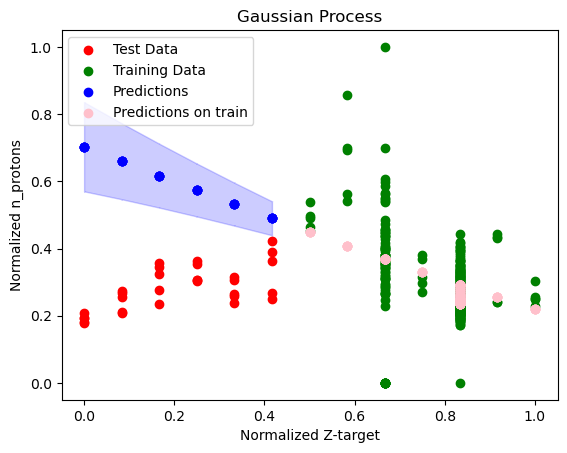

In [17]:

plt.figure()

# Scatter plot of the actual test data
plt.scatter(normed_z_test_set_1.numpy(), normed_n_test_set_1.numpy(), c='r', label='Test Data')
plt.scatter(normed_z_train_set_1.numpy(), normed_n_train_set_1.numpy(), c='g', label='Training Data')

plt.scatter(normed_z_test_set_1.numpy(), test_mean_prediction_set_1.numpy(), c='b', label='Predictions')
plt.scatter(normed_z_train_set_1.numpy(), train_mean_prediction_set_1.numpy(), c='pink', label='Predictions on train')

plt.xlabel('Normalized Z-target')
plt.ylabel('Normalized n_protons')
plt.title('Gaussian Process')
plt.legend()

# Fill between the prediction intervals
plt.fill_between(normed_z_test_set_1.squeeze().numpy(), test_lower_set_1.numpy(), test_upper_set_1.numpy(), alpha=0.2, color='b', label='Confidence Interval')
# Show the plot
plt.savefig("GP_A.png")
plt.show()

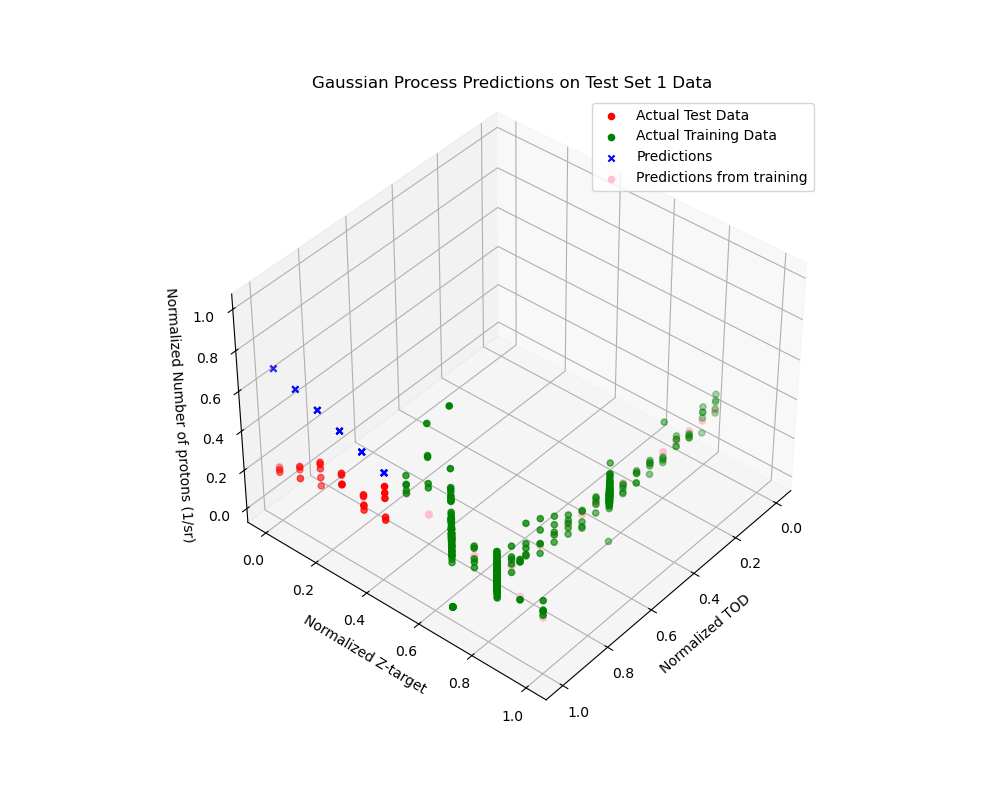

In [18]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib widget


fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of the actual test data
ax.scatter(normed_TOD_test_set_1.numpy(), normed_z_test_set_1.numpy(), normed_n_test_set_1.numpy(), c='r', label='Actual Test Data')

# Scatter plot of the training data
ax.scatter(normed_TOD_train_set_1.numpy(), normed_z_train_set_1.numpy(), normed_n_train_set_1.numpy(), c='g', label='Actual Training Data')

# Scatter plot of the predictions
ax.scatter(normed_TOD_test_set_1.numpy(), normed_z_test_set_1.numpy(), test_mean_prediction_set_1.numpy(), c='b', marker='x', label='Predictions')

# Scatter plot of the predictions
ax.scatter(normed_TOD_train_set_1.numpy(), normed_z_train_set_1.numpy(), train_mean_prediction_set_1.numpy(), c='pink', label='Predictions from training')


ax.view_init(elev=40, azim=40, roll=0)
# Labels and legend
ax.set_xlabel('Normalized TOD')
ax.set_ylabel('Normalized Z-target')
ax.set_zlabel('Normalized Number of protons (1/sr)')
ax.set_title('Gaussian Process Predictions on Test Set 1 Data')
ax.legend()

plt.savefig("GP_adam.png")
plt.show()

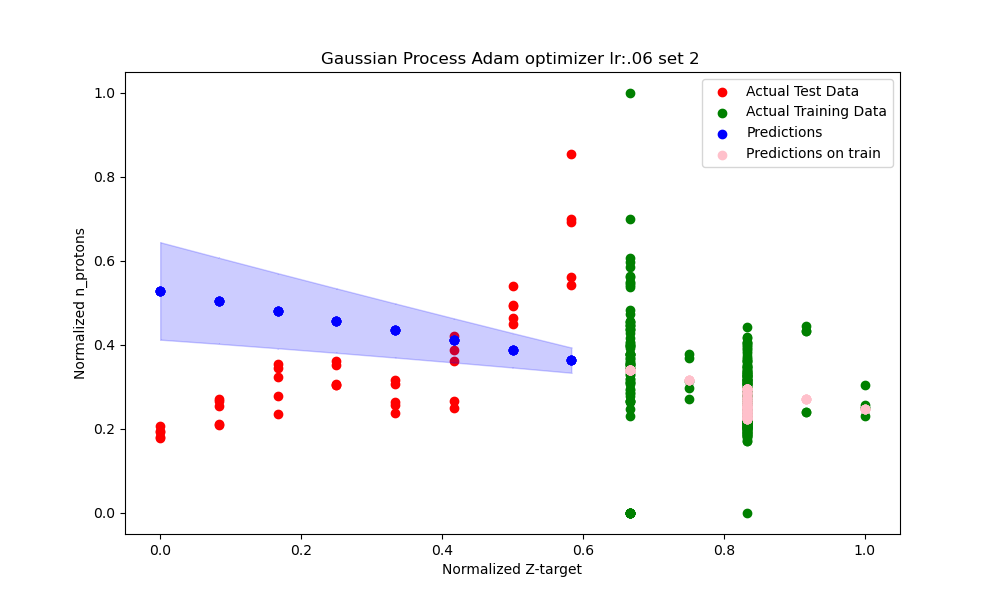

In [19]:
# Example plotting (requires matplotlib)
plt.figure(figsize=(10, 6))

# Scatter plot of the actual test data
plt.scatter(normed_z_test_set_2.numpy(), normed_n_test_set_2.numpy(), c='r', label='Actual Test Data')
plt.scatter(normed_z_train_set_2.numpy(), normed_n_train_set_2.numpy(), c='g', label='Actual Training Data')

plt.scatter(normed_z_test_set_2.numpy(), test_mean_prediction_set_2.numpy(), c='b', label='Predictions')
plt.scatter(normed_z_train_set_2.numpy(), train_mean_prediction_set_2.numpy(), c='pink', label='Predictions on train')

plt.xlabel('Normalized Z-target')
plt.ylabel('Normalized n_protons')
plt.title('Gaussian Process Adam optimizer lr:.06 set 2 ')
plt.legend()

# Fill between the prediction intervals
plt.fill_between(normed_z_test_set_2.squeeze().numpy(), test_lower_set_2.numpy(), test_upper_set_2.numpy(), alpha=0.2, color='b', label='Confidence Interval')
# Show the plot
plt.show()

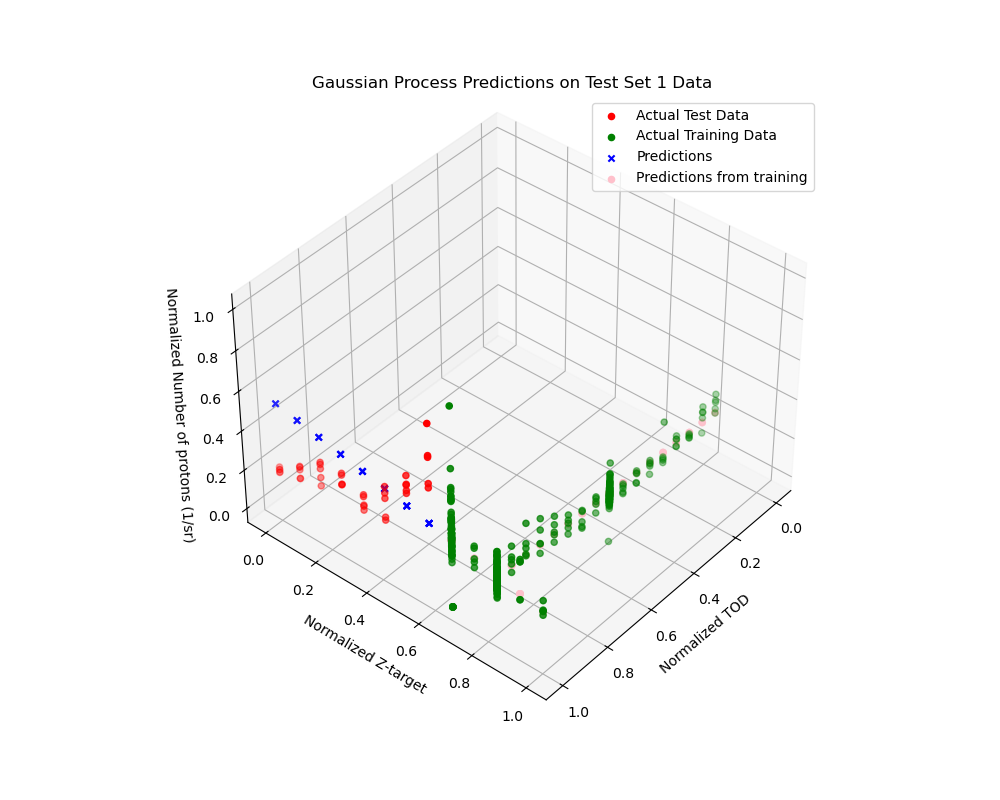

In [20]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib widget


fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of the actual test data
ax.scatter(normed_TOD_test_set_2.numpy(), normed_z_test_set_2.numpy(), normed_n_test_set_2.numpy(), c='r', label='Actual Test Data')

# Scatter plot of the training data
ax.scatter(normed_TOD_train_set_2.numpy(), normed_z_train_set_2.numpy(), normed_n_train_set_2.numpy(), c='g', label='Actual Training Data')

# Scatter plot of the predictions
ax.scatter(normed_TOD_test_set_2.numpy(), normed_z_test_set_2.numpy(), test_mean_prediction_set_2.numpy(), c='b', marker='x', label='Predictions')

# Scatter plot of the predictions
ax.scatter(normed_TOD_train_set_2.numpy(), normed_z_train_set_2.numpy(), train_mean_prediction_set_2.numpy(), c='pink', label='Predictions from training')


ax.view_init(elev=40, azim=40, roll=0)
# Labels and legend
ax.set_xlabel('Normalized TOD')
ax.set_ylabel('Normalized Z-target')
ax.set_zlabel('Normalized Number of protons (1/sr)')
ax.set_title('Gaussian Process Predictions on Test Set 1 Data')
ax.legend()

plt.savefig("GP_adam.png")
plt.show()